In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.
C:\Users\SOUMEL ZUTSHI\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\SOUMEL ZUTSHI\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\SOUMEL ZUTSHI\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users

In [43]:
#load the file
def load_doc(filename):
    file = open(filename,'r')
    text = file.read()
    file.close()
    return text


filename = r"C:\Users\SOUMEL ZUTSHI\Downloads\Flickr8k_text (1)\Flickr8k.token.txt"
    
doc = load_doc(filename)

print(doc[:581])
    

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .


In [44]:
#Load the descriptions
def load_descriptions(doc):
    mapping = dict()
    
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
            
        image_id , image_desc = tokens[0] , tokens[1:]
        
        image_id = image_id.split('.')[0]
        
        image_desc = ' '.join(image_desc)
        
        if image_id not in mapping:
            mapping[image_id] = list()
        
        mapping[image_id].append(image_desc)
    return mapping

descriptions = load_descriptions(doc)
print('Loaded: %d' % len(descriptions))
        

Loaded: 8092


In [45]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [46]:
list(descriptions.items())[:5]

[('1000268201_693b08cb0e',
  ['A child in a pink dress is climbing up a set of stairs in an entry way .',
   'A girl going into a wooden building .',
   'A little girl climbing into a wooden playhouse .',
   'A little girl climbing the stairs to her playhouse .',
   'A little girl in a pink dress going into a wooden cabin .']),
 ('1001773457_577c3a7d70',
  ['A black dog and a spotted dog are fighting',
   'A black dog and a tri-colored dog playing with each other on the road .',
   'A black dog and a white dog with brown spots are staring at each other in the street .',
   'Two dogs of different breeds looking at each other on the road .',
   'Two dogs on pavement moving toward each other .']),
 ('1002674143_1b742ab4b8',
  ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
   'A little girl is sitting in front of a large painted rainbow .',
   'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it

In [47]:
def clean_descriptions(descriptions):
    table = str.maketrans("","",string.punctuation)
    for key , desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            
            #TOKENIZE
            desc = desc.split()
            
            #Convert to lower case
            desc = [word.lower() for word in desc]
            
            #remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            
            #remove single characters like 'a'
            desc = [word for word in desc if len(word)>1]
            
            #remove tokens with numbers
            desc = [word for word in desc if word.isalpha()]
            
            #store as a string
            desc_list[i] = ' '.join(desc)
            
            
clean_descriptions(descriptions)

In [48]:
list(descriptions.items())[:5]

[('1000268201_693b08cb0e',
  ['child in pink dress is climbing up set of stairs in an entry way',
   'girl going into wooden building',
   'little girl climbing into wooden playhouse',
   'little girl climbing the stairs to her playhouse',
   'little girl in pink dress going into wooden cabin']),
 ('1001773457_577c3a7d70',
  ['black dog and spotted dog are fighting',
   'black dog and tricolored dog playing with each other on the road',
   'black dog and white dog with brown spots are staring at each other in the street',
   'two dogs of different breeds looking at each other on the road',
   'two dogs on pavement moving toward each other']),
 ('1002674143_1b742ab4b8',
  ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
   'little girl is sitting in front of large painted rainbow',
   'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
   'there is girl with pigtails sitting in front of rainbow painting',

In [49]:
def vocab(descriptions):
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

vocabulary = vocab(descriptions)
print('Original Vocabulary Size: %d' %len(vocabulary))

Original Vocabulary Size: 8763


In [50]:
def save_descriptions(descriptions,filename):
    lines = list()
    for key , desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename,'w')
    file.write(data)
    file.close()
    
save_descriptions(descriptions,'descriptions.txt')

In [51]:
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        
        identifier = line.split('.')[0]
        dataset.append(identifier)
    
    return set(dataset)

filename = r'C:\Users\SOUMEL ZUTSHI\Downloads\Flickr8k_text (1)\Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))


Dataset: 6000


In [52]:
images = r'C:\Users\SOUMEL ZUTSHI\Downloads\Flickr8k_Dataset(2)\Flicker8k_Dataset/'

img = glob.glob(images + '*.jpg')
print(len(img))

8091


In [53]:
train_images_file = r'C:\Users\SOUMEL ZUTSHI\Downloads\Flickr8k_text (1)\Flickr_8k.trainImages.txt'

train_images = set(open(train_images_file,'r').read().strip().split('\n'))

train_img = []

for i in img:
    if i[len(images):] in train_images:
        train_img.append(i)
        
print(len(train_images))
print(len(images))
print(len(train_img))

6000
71
6000


In [54]:
test_image_file = r'C:\Users\SOUMEL ZUTSHI\Downloads\Flickr8k_text (1)\Flickr_8k.testImages.txt'

test_images = set(open(test_image_file,'r').read().strip().split('\n'))

test_img = []

for i in img:
    if i [len(images):] in test_images:
        test_img.append(i)
        
print(len(test_images))
print(len(images))

1000
71


In [148]:
#LOAD CLEAD DESCRIPTIONS IN MEMORY
def load_clean_descriptions(filename,dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        
        tokens = line.split()
        
        image_id , image_desc = tokens[0] , tokens[1:]
        if image_id in dataset:        
            if image_id not in descriptions:
                descriptions[image_id] = list()
            
            desc = ' ' + ' '.join(image_desc) + ' '
        
            descriptions[image_id].append(desc)
    return descriptions

train_descriptions = load_clean_descriptions(r'C:\Users\SOUMEL ZUTSHI\descriptions.txt',train)
print('Descriptions: train = %d' % len(train_descriptions))

Descriptions: train = 6000


In [149]:
type(train_descriptions)

dict

In [57]:
def preprocess(image_path):
    
    img = image.load_img(image_path , target_size = (299,299))
    
    x = image.img_to_array(img)
    
    x = np.expand_dims(x,axis=0)
    
    x = preprocess_input(x)
    
    return x
# preprocess will return x as (samples,shape,shape,channels)

In [58]:
model = InceptionV3(weights='imagenet')

In [59]:
model_new = Model(model.input,model.layers[-2].output) #removing the last layer i.e the output layer

In [60]:
#function to encode the given image into a vector of size (2048,)
def encode(image):
    image = preprocess(image) #preprocess the image first
    
    fea_vec = model_new.predict(image) # get the encoding vector for the image
    
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) #change shape from (1,2048) to (2048, )
    
    return fea_vec

In [61]:
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds = ",time() - start)

Time taken in seconds =  3434.665498495102


In [62]:
import pickle

In [68]:
with open(r'C:\Users\SOUMEL ZUTSHI\Downloads\Flickr8k_Dataset(2)\Pickle\encoded_train_images.pkl',"wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [69]:
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 517.4781053066254


In [70]:
with open(r"C:\Users\SOUMEL ZUTSHI\Downloads\Flickr8k_Dataset(2)/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [71]:
train_features = load(open(r"C:\Users\SOUMEL ZUTSHI\Downloads\Flickr8k_Dataset(2)/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [150]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [151]:
word_count_threshold = 10 
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w,0) + 1
        
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts),len(vocab)))

preprocessed words 7577 -> 1650


In [74]:
print(type(vocab))
print(len(vocab))

<class 'list'>
1961


In [152]:
ixtoword = {} # index to word
wordtoix = {} # word to index

ix = 1

for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [153]:
vocab_size = len(ixtoword) + 1 # 1 is added as index start from 0
vocab_size

1651

In [154]:
def to_lines(descriptions):
        all_desc = list()
        for key in descriptions.keys():
                [all_desc.append(d) for d in descriptions[key]]
        return all_desc
    
#calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

#determine the max sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)


Description Length: 32


In [155]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [156]:
# load glove vectors
glove_dir = r'C:\Users\SOUMEL ZUTSHI\Downloads\glove.6B'
embeddings_index = {} #empty dictionary
f = open(os.path.join(glove_dir,'glove.6B.200d.txt'),encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word] = coefs
    
f.close()
print('Found %s word vectors' % len(embeddings_index))

Found 400000 word vectors


In [157]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size,embedding_dim))

for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [158]:
embedding_matrix.shape

(1651, 200)

In [159]:
#MODEL    
#feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

#Sequence Model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size , embedding_dim , mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
    
#Decoder Model
decoder1 = add([fe2, se3])
decoder2 = Dense(256 , activation='relu')(decoder1)
outputs = Dense(vocab_size , activation='softmax')(decoder2)
    
model = Model(inputs=[inputs1,inputs2], outputs=outputs)   
    

In [160]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 32, 200)      330200      input_8[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           input_7[0][0]                    
__________________________________________________________________________________________________
dropout_6 

In [161]:
model.layers[2]

In [162]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [163]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [164]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [165]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    

Epoch 1/1
2000/2000 [==============================] - 1672s 836ms/step - loss: 4.1235
Epoch 1/1
2000/2000 [==============================] - 1639s 820ms/step - loss: 3.4214
Epoch 1/1
2000/2000 [==============================] - 1643s 821ms/step - loss: 3.2006
Epoch 1/1
2000/2000 [==============================] - 1641s 820ms/step - loss: 3.0677
Epoch 1/1
2000/2000 [==============================] - 1643s 821ms/step - loss: 2.9718
Epoch 1/1
2000/2000 [==============================] - 1641s 821ms/step - loss: 2.8986
Epoch 1/1
2000/2000 [==============================] - 1639s 819ms/step - loss: 2.8400
Epoch 1/1
2000/2000 [==============================] - 1643s 821ms/step - loss: 2.7902
Epoch 1/1
2000/2000 [==============================] - 1648s 824ms/step - loss: 2.7505
Epoch 1/1
2000/2000 [==============================] - 1656s 828ms/step - loss: 2.7192


In [173]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)

Epoch 1/1
1000/1000 [==============================] - 1306s 1s/step - loss: 2.3848
Epoch 1/1
1000/1000 [==============================] - 1294s 1s/step - loss: 2.3751
Epoch 1/1
1000/1000 [==============================] - 1293s 1s/step - loss: 2.3688
Epoch 1/1
1000/1000 [==============================] - 1293s 1s/step - loss: 2.3635
Epoch 1/1
1000/1000 [==============================] - 1323s 1s/step - loss: 2.3599
Epoch 1/1
1000/1000 [==============================] - 1292s 1s/step - loss: 2.3510
Epoch 1/1
1000/1000 [==============================] - 1293s 1s/step - loss: 2.3475
Epoch 1/1
1000/1000 [==============================] - 1293s 1s/step - loss: 2.3419
Epoch 1/1
1000/1000 [==============================] - 1311s 1s/step - loss: 2.3366
Epoch 1/1
1000/1000 [==============================] - 1296s 1s/step - loss: 2.3349


In [174]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_batch = 6
steps = len(train_descriptions)//number_pics_per_batch

In [175]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)

Epoch 1/1
1000/1000 [==============================] - 1292s 1s/step - loss: 2.3262
Epoch 1/1
1000/1000 [==============================] - 1295s 1s/step - loss: 2.3226
Epoch 1/1
1000/1000 [==============================] - 1300s 1s/step - loss: 2.3164
Epoch 1/1
1000/1000 [==============================] - 1318s 1s/step - loss: 2.3131
Epoch 1/1
1000/1000 [==============================] - 1314s 1s/step - loss: 2.3108
Epoch 1/1
1000/1000 [==============================] - 1296s 1s/step - loss: 2.3027
Epoch 1/1
1000/1000 [==============================] - 1291s 1s/step - loss: 2.2980
Epoch 1/1
1000/1000 [==============================] - 1296s 1s/step - loss: 2.2966
Epoch 1/1
1000/1000 [==============================] - 1297s 1s/step - loss: 2.2943
Epoch 1/1
1000/1000 [==============================] - 1303s 1s/step - loss: 2.2905


In [176]:
images = r'C:\Users\SOUMEL ZUTSHI\Downloads\Flickr8k_Dataset(2)\Flicker8k_Dataset/'

In [177]:
with open(r'C:\Users\SOUMEL ZUTSHI\Downloads\Flickr8k_Dataset(2)\Pickle/encoded_test_images.pkl','rb') as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [178]:
def Search(photos):
    in_text = 'startseq '
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photos,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word + ' '
        if word == ' endseq ':
            break
    final = in_text.split()
    final = final[0:]
    final = ' '.join(final)
    return final

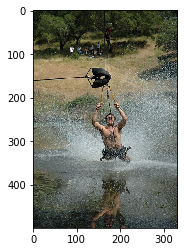

Caption: startseq the man is jumping into the water


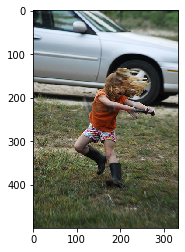

Caption: startseq boy in red shirt is running away from the grass


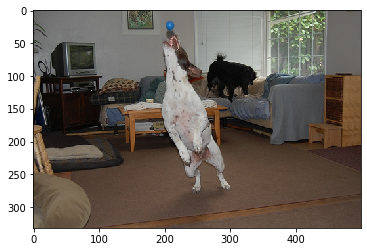

Caption: startseq two girls are playing on the carpet


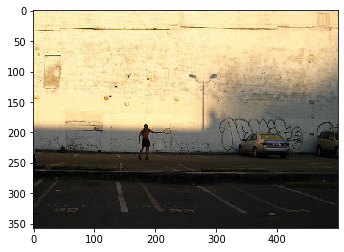

Caption: startseq is parked in the city


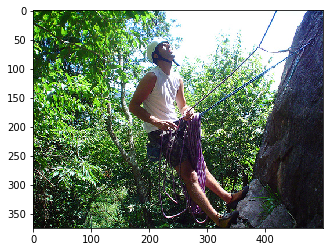

Caption: startseq man in white shirt is climbing rock


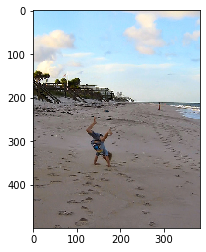

Caption: startseq six girls are walking on rocks along the water


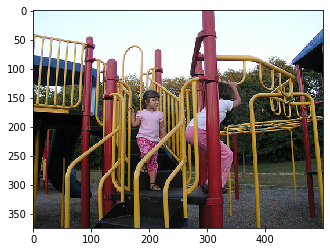

Caption: startseq the little boy is playing on the round equipment


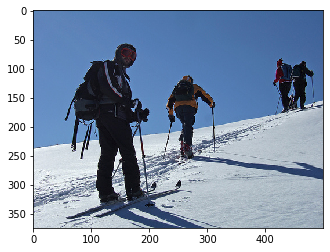

Caption: startseq hiker skiing downhill


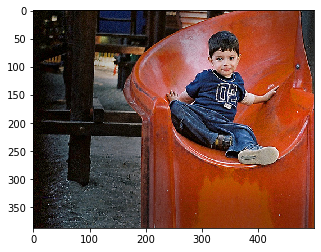

Caption: startseq the little boy is wearing red shirt and is standing in front of wooden


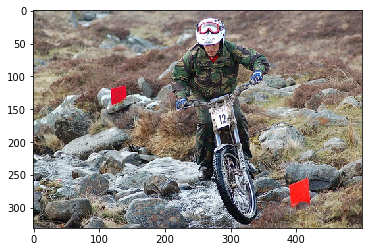

Caption: startseq bike rider is riding on trail


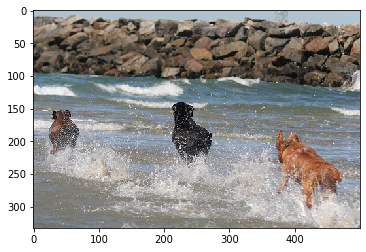

Caption: startseq two dogs are playing in the water


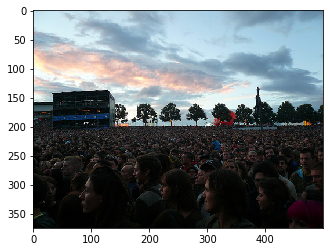

Caption: startseq crowd of people are sitting in fire waving american flags


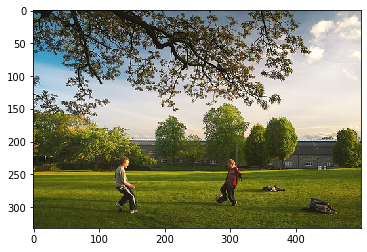

Caption: startseq six children are playing with ball in the grass


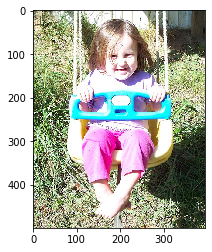

Caption: startseq the little boy is happily on swing


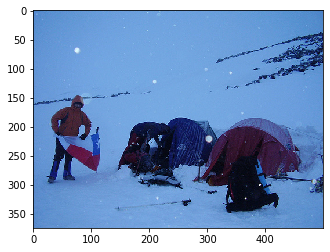

Caption: startseq group of people are walking through the snow


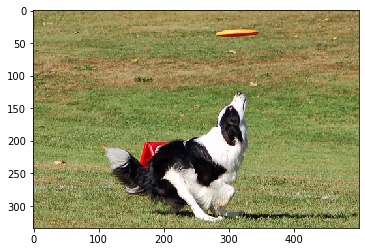

Caption: startseq two dogs are playing with frisbee in the grass


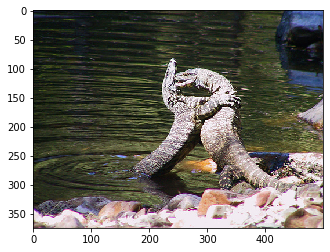

Caption: startseq the dog is wading in the water


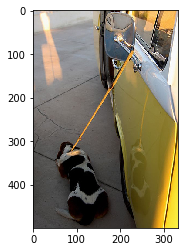

Caption: startseq animals in front of bus


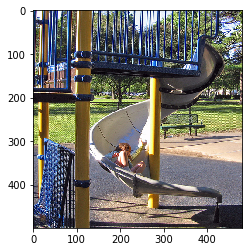

Caption: startseq the little boy is jumping off of the trampoline


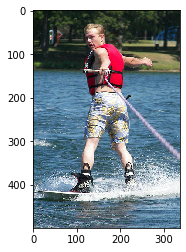

Caption: startseq the surfer is riding the wave whilst riding the water


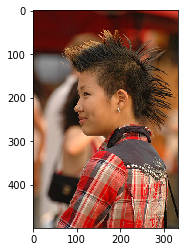

Caption: startseq redheaded boy with dirty hair and blue eyes is standing in the street


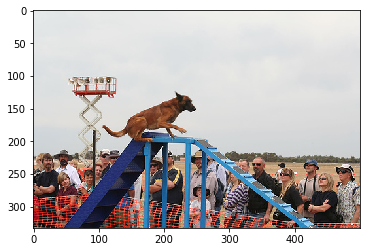

Caption: startseq dog jumps over hurdles


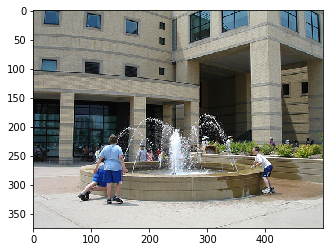

Caption: startseq children play in the sprinklers


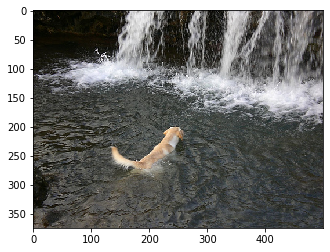

Caption: startseq the person is in the water with his dog in his mouth


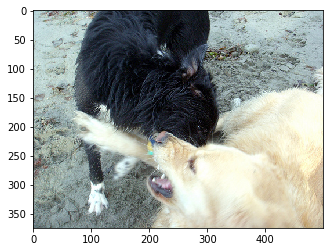

Caption: startseq two dogs play together in the grass


In [204]:
for z in range(50,100,2):
    pic = list(encoding_test.keys())[z]
    image = encoding_test[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print("Caption:",Search(image))